Generate Synthetic data from a $N(0, 1/d I_d)$ distribution and fit a neural net to the data with $nd$ parameters, and fit a two layer NN to the data with nd parameters.


In [ ]:
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import math

drive.mount('/content/drive')


def calculate_gradients(model, inputs):
        inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)

        with tf.GradientTape() as tape:
            tape.watch(inputs)
            outputs = model(inputs)

        gradients = tape.gradient(outputs, inputs)

        return gradients.numpy()

class CustomEarlyStopping(Callback):
        def __init__(self, epsilon):
            super(CustomEarlyStopping, self).__init__()
            self.epsilon = epsilon

        def on_epoch_end(self, epoch, logs=None):
            train_loss = logs.get('loss')
            if train_loss <= self.epsilon:
                print(f"\nReached training loss of {train_loss}, stopping training")
                self.model.stop_training = True

Mounted at /content/drive



Reached training loss of 0.08224193006753922, stopping training

Reached training loss of 0.04911523312330246, stopping training

Reached training loss of 0.08341136574745178, stopping training

Reached training loss of 0.04524240270256996, stopping training

Reached training loss of 0.07918615639209747, stopping training


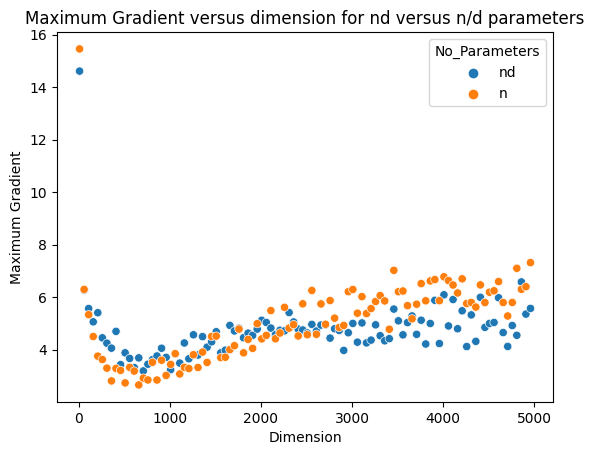

In [ ]:

maxgradnd = []
maxgradnod = []
dim = []
n_samples = 10000

d_samp  = np.arange(10, 5000, 50)

for d in d_samp:
  #generate random data
  mean = np.zeros(d)
  cov = 1/d*np.identity(d)
  X = np.random.multivariate_normal(mean, cov, n_samples)
  y = np.random.choice([-1, 1], size=n_samples)

  #define the model with nd parameters

  modelnd = Sequential([
      Dense(n_samples, activation='relu', input_shape=(d,)),
      Dense(1, activation='tanh')
  ])

  epsilon = 0.1
  custom_early_stopping = CustomEarlyStopping(epsilon)

  modelnd.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
  #train the model
  epochs = 100000
  batch_size = 50

  history = modelnd.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0, callbacks=[custom_early_stopping])


  ## Compute the maximum random gradient

  T = np.random.multivariate_normal(mean, cov, 1000)
  gradients1 = calculate_gradients(modelnd, T)

  maxgradnd.append(np.max(np.abs(gradients1)))

  #define the model wiht 10*n parameters

  modelnod = Sequential([
      Dense(10*n_samples/d, activation='relu', input_shape=(d,)),
      Dense(1, activation='tanh')
  ])

  modelnod.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
  history = modelnod.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0, callbacks=[custom_early_stopping])


  ## Compute the maximum random gradient
  gradients2 = calculate_gradients(modelnod, T)
  maxgradnod.append(np.max(np.abs(gradients2)))
  dim.append(d)

# Create a DataFrame for the data
data = pd.DataFrame({
    'nd': maxgradnd,
    'n': maxgradnod,
    'd': dim
})

# Melt the DataFrame into a long format
data_melted = data.melt(id_vars='d', var_name='No_Parameters', value_name='Maximum Gradient')

sns.scatterplot(data=data_melted, y='Maximum Gradient', x='d', hue='No_Parameters')

plt.xlabel('Dimension')
plt.ylabel('Maximum Gradient')
plt.title('Maximum Gradient versus dimension for nd versus n/d parameters')

plt.show()


Generate the figure:

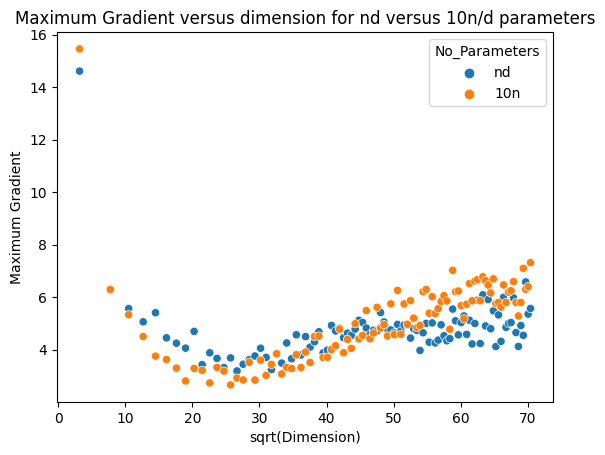

In [ ]:
# Create a DataFrame for the data
sqdim = [math.sqrt(x) for x in dim]
data = pd.DataFrame({
    'nd': maxgradnd,
    '10n': maxgradnod,
    'd': sqdim
})

# Melt the DataFrame into a long format
data_melted = data.melt(id_vars='d', var_name='No_Parameters', value_name='Maximum Gradient')

sns.scatterplot(data=data_melted, y='Maximum Gradient', x='d', hue='No_Parameters')

plt.xlabel('sqrt(Dimension)')
plt.ylabel('Maximum Gradient')
plt.title('Maximum Gradient versus dimension for nd versus 10n/d parameters')

plt.show()

In [ ]:
## save data so that it can be reloaded without running code again
np.savez('simndnod.npz', maxgradnd=maxgradnd, maxgradnod=maxgradnod, dim = dim)


In [ ]:
#loaded_data = np.load('simndnod.npz')
#maxgradnd = loaded_data['maxgradnd']
#maxgradnod = loaded_data['maxgradnod']
#dim = loaded_data['dim']

MNIST model

In [ ]:
from tensorflow.keras.layers import Flatten
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalize the images
X_train = X_train / 255.0
X_test = X_test / 255.0

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

#compute the number of parameters in the hidden layer of the nn
n = 3*10**6
i = 784
o = 10

h = int((n - o * 10) / (i + o))

# Define the model with 3*10^6 parameters
modelmnistnd = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(h, activation='relu'),
    Dense(10, activation='softmax')
])

modelmnistnd.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

epsilon = 0.0000000001
custom_early_stopping = CustomEarlyStopping(epsilon)

checkpoint_path = "checkpoints/cp-{epoch:04d}.ckpt"

class CustomModelCheckpoint(ModelCheckpoint):
    def __init__(self, epochs_to_save, *args, **kwargs):
        super(CustomModelCheckpoint, self).__init__(*args, **kwargs)
        self.epochs_to_save = epochs_to_save

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.epochs_to_save == 0:
            super().on_epoch_end(epoch, logs)

custom_model_checkpoint = CustomModelCheckpoint(
    epochs_to_save=500,
    filepath=checkpoint_path,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)



In [ ]:
# Train the model
epochs = 100000
batch_size = 32

history = modelmnistnd.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0, callbacks=[custom_early_stopping, custom_model_checkpoint])



Epoch 1: val_loss improved from inf to 0.11251, saving model to checkpoints/cp-0001.ckpt

Reached training loss of 7.202227009228679e-11, stopping training


In [ ]:
test_loss, test_accuracy = modelmnistnd.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)




In [ ]:
# Define the model with 2n parameters
n = 120000
i = 784
o = 10

h = int((n - o * 10) / (i + o))

modelmnistminimal = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(h, activation='relu'),
    Dense(10, activation='softmax')
])

epsilon = 0.0000000001
custom_early_stopping = CustomEarlyStopping(epsilon)

modelmnistminimal.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# run the smaller model
history = modelmnistminimal.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=2, callbacks=[custom_early_stopping, custom_model_checkpoint])


In [ ]:
save_path = '/content/drive/MyDrive/saved_models/mnistminimal'

tf.keras.models.save_model(
    model=modelmnistminimal,
    filepath=save_path,
    overwrite=True,
    include_optimizer=True,
    save_format='tf',
    signatures=None,
    options=None
)


save_path2 = '/content/drive/MyDrive/saved_models/mnistnd'


tf.keras.models.save_model(
    model=modelmnistnd,
    filepath=save_path2,
    overwrite=True,
    include_optimizer=True,
    save_format='tf',
    signatures=None,
    options=None
)


Test performance on mnist corrupted

In [ ]:
!pip install foolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tensorflow.keras.models import load_model
import foolbox as fb
import eagerpy as ep


## load previously trained model
mistnd = tf.keras.models.load_model('/content/drive/MyDrive/saved_models/mnistnd')



In [ ]:
adv_loss, adv_accuracy = mnistnd.evaluate(X_train, y_train, verbose=0)
print(f"Training accuracy: {train_accuracy * 100:.2f}%")
print(f"Training loss: {train_loss}")
total_params = sum([tf.keras.backend.count_params(w) for w in mnistnd.trainable_variables])
print(total_params)


In [ ]:
train_loss = history.history['loss'][-1]
print(f"final training loss: {train_loss}")


final training loss: 8.279472467620508e-07


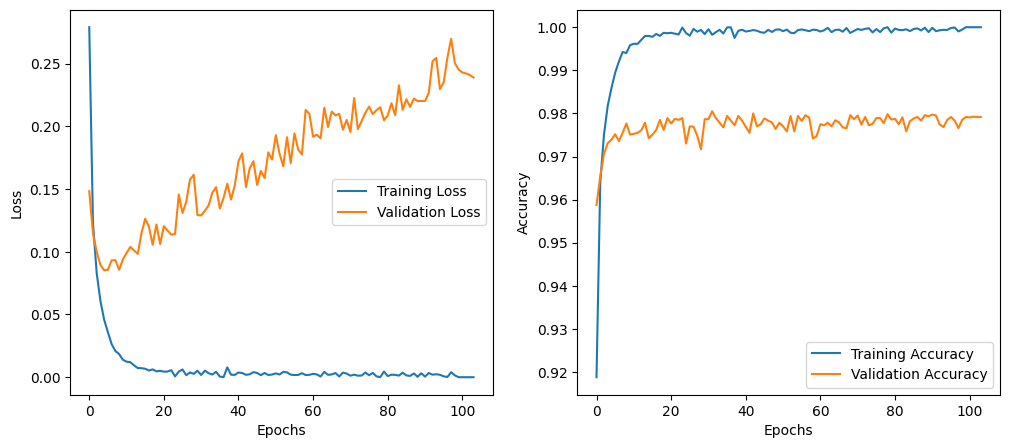

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



## Retry Random Data Example with Batch normalization.


In [ ]:
from tensorflow.keras.layers import BatchNormalization

maxgradnd = []
maxgradnod = []
dim = []
n_samples = 10000

d_samp  = np.arange(10, 5000, 50)

for d in d_samp:
  #generate random data
  mean = np.zeros(d)
  cov = 1/d*np.identity(d)
  X = np.random.multivariate_normal(mean, cov, n_samples)
  y = np.random.choice([-1, 1], size=n_samples)

  #define the model with nd parameters

  modelnd = Sequential([
      Dense(n_samples, activation='relu', input_shape=(d,)),
      BatchNormalization(),
      Dense(1, activation='tanh')
  ])

  epsilon = 0.1
  custom_early_stopping = CustomEarlyStopping(epsilon)

  modelnd.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
  #train the model
  epochs = 100000
  batch_size = 50

  history = modelnd.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0, callbacks=[custom_early_stopping])


  ## Compute the maximum random gradient

  T = np.random.multivariate_normal(mean, cov, 1000)
  gradients1 = calculate_gradients(modelnd, T)

  maxgradnd.append(np.max(np.abs(gradients1)))

  #define the model wiht 10*n parameters

  modelnod = Sequential([
      Dense(10*n_samples/d, activation='relu', input_shape=(d,)),
      BatchNormalization(),
      Dense(1, activation='tanh')
  ])

  modelnod.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
  history = modelnod.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0, callbacks=[custom_early_stopping])


  ## Compute the maximum random gradient
  gradients2 = calculate_gradients(modelnod, T)
  maxgradnod.append(np.max(np.abs(gradients2)))
  dim.append(d)

# Create a DataFrame for the data
data = pd.DataFrame({
    'nd': maxgradnd,
    'n': maxgradnod,
    'd': dim
})

# Melt the DataFrame into a long format
data_melted = data.melt(id_vars='d', var_name='No_Parameters', value_name='Maximum Gradient')

sns.scatterplot(data=data_melted, y='Maximum Gradient', x='d', hue='No_Parameters')

plt.xlabel('Dimension')
plt.ylabel('Maximum Gradient')
plt.title('Maximum Gradient versus dimension for nd versus 10n parameters')

plt.show()



Reached training loss of 0.09983551502227783, stopping training


In [ ]:
# Create a DataFrame for the data
sqdim = [math.sqrt(x) for x in dim]
data = pd.DataFrame({
    'nd': maxgradnd,
    '10n': maxgradnod,
    'd': sqdim
})

# Melt the DataFrame into a long format
data_melted = data.melt(id_vars='d', var_name='No_Parameters', value_name='Maximum Gradient')

sns.scatterplot(data=data_melted, y='Maximum Gradient', x='d', hue='No_Parameters')

plt.xlabel('sqrt(Dimension)')
plt.ylabel('Maximum Gradient')
plt.title('Maximum Gradient versus dimension for nd versus 10n parameters')

plt.show()